# Preprocessing

## Imports

In [1]:
import re
import yaml
import random
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 

from wordcloud import WordCloud

import sys
sys.path.append("../")
from src.data_preparation import *
from src.utility import *

## Loading the config File

In [2]:
with open("../config.yaml") as f:
    config = yaml.safe_load(f)
    config = config["preprocessing"]
config

{'paths': {'raw_data': 'data/raw/IMDB_Dataset.csv',
  'interim_data': 'data/interim/IMDB_explored.csv',
  'cleaned_data': 'data/interim/IMDB_cleaned.pkl',
  'processed_data': 'data/processed/',
  'models': 'models/'},
 'cleaning': {'lowercase': True,
  'strip_html': True,
  'remove_urls': True,
  'remove_emails': True,
  'remove_punctuation': True,
  'remove_numbers': False,
  'remove_control_chars': True,
  'remove_emoji': True,
  'normalize_unicode': True,
  'expand_contractions': True,
  'replace_whitespace': True,
  'normalize_elongations': True,
  'remove_stopwords': True,
  'lemmatize': True,
  'stem': False,
  'alpha_only': True,
  'min_token_length': 2},
 'stopwords': {'source': 'nltk', 'add_custom': [], 'remove_custom': []},
 'intermediate': {'save_fig': True,
  'fig_dir': 'results/figures/',
  'format': 'pkl',
  'sample_rows_to_check': 10}}

In [3]:
# ---------------- Paths ---------------- #
RAW_DATA = os.path.join("../", config["paths"]["raw_data"])
INTERIM_DATA = os.path.join("../", config["paths"]["interim_data"])
CLEANED_DATA = os.path.join("../", config["paths"]["cleaned_data"])
PROCESSED_DATA = os.path.join("../", config["paths"]["processed_data"])
MODES = os.path.join("../", config["paths"]["models"])

# ---------------- Cleaning ---------------- #
LOWERCASE = config["cleaning"]["lowercase"]
STRIP_HTML = config["cleaning"]["strip_html"]
REMOVE_URLS = config["cleaning"]["remove_urls"]
REMOVE_EMAILS = config["cleaning"]["remove_emails"]
REMOVE_PUNCTUATION = config["cleaning"]["remove_punctuation"]
REMOVE_NUMBERS = config["cleaning"]["remove_numbers"]
REMOVE_CONTROL_CHARS = config["cleaning"]["remove_control_chars"]
REMOVE_EMOJI = config["cleaning"]["remove_emoji"]
NORMALIZE_UNICODE = config["cleaning"]["normalize_unicode"]
EXPAND_CONTRACTIONS = config["cleaning"]["expand_contractions"]
REPLACE_WHITESPACE = config["cleaning"]["replace_whitespace"]
NORMALIZE_ELONGATIONS = config["cleaning"]["normalize_elongations"]
REMOVE_STOPWORDS = config["cleaning"]["remove_stopwords"]
LEMMATIZE = config["cleaning"]["lemmatize"]
STEM = config["cleaning"]["stem"]
ALPHA_ONLY = config["cleaning"]["alpha_only"]
MIN_TOKEN_LENGTH = config["cleaning"]["min_token_length"]

# ---------------- Stopwords ---------------- #
STOPWORDS_SOURCE = config["stopwords"]["source"]
STOPWORDS_ADD_CUSTOM = config["stopwords"]["add_custom"]
STOPWORDS_REMOVE_CUSTOM = config["stopwords"]["remove_custom"]

# ---------------- Intermediate ---------------- #
SAVE_FIG = config["intermediate"]["save_fig"]
FIG_DIR = os.path.join("../", config["intermediate"]["fig_dir"])
FORMAT = config["intermediate"]["format"]
SAMPLE_ROWS_TO_CHECK = config["intermediate"]["sample_rows_to_check"]

## Loading the data

In [4]:
df = load_data_csv(INTERIM_DATA)
df

,review,sentiment,review_charecters_len,review_word_len,has_html
0,One of the other reviewers has mentioned that ...,positive,1377,320,True
1,A wonderful little production. <br /><br />The...,positive,793,166,True
2,I thought this was a wonderful way to spend ti...,positive,721,172,True
3,Basically there's a family where a little boy ...,negative,569,141,True
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1032,236,True
...,...,...,...,...,...
49995,I thought this movie did a down right good job...,positive,769,205,True
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,505,115,True
49997,I am a Catholic taught in parochial elementary...,negative,1006,240,True
49998,I'm going to have to disagree with the previou...,negative,995,217,False


## Cleaning Pipeline

In [5]:
def clean_text_pipeline(text):
    if STRIP_HTML:
        text = strip_html(text)
    if NORMALIZE_UNICODE:
        text = normalize_unicode_text(text)
    if REMOVE_CONTROL_CHARS:
        text = remove_control_chars(text)
    if REPLACE_WHITESPACE:
        text = replace_whitespace(text)
    if LOWERCASE:
        text = text.lower()
    if EXPAND_CONTRACTIONS:
        text = expand_contractions(text)
    if REMOVE_URLS:
        text = remove_urls(text)
    if REMOVE_EMAILS:
        text = remove_emails(text)
    if REMOVE_PUNCTUATION:
        text = remove_punctuation(text)
    if NORMALIZE_ELONGATIONS:
        text = normalize_elongations(text)
    
    tokens = tokenize(text)
    
    if REMOVE_STOPWORDS:
        stopword_list = set(stopwords.words("english"))
        # add/remove custom stopwords
        stopword_list.update(STOPWORDS_ADD_CUSTOM)
        stopword_list.difference_update(STOPWORDS_REMOVE_CUSTOM)
        tokens = remove_stopwords(tokens, stopword_list)
    
    if LEMMATIZE:
        lemmatizer = WordNetLemmatizer()
        tokens = lemmatize(tokens, lemmatizer)
    
    tokens = filter_tokens(tokens, min_len=MIN_TOKEN_LENGTH, alpha_only=ALPHA_ONLY)
    
    cleaned_text = reconstruct_text(tokens)
    return cleaned_text, tokens

## Applying the pipeline to the dataset

In [6]:
%time df["cleaned_review"], df["tokens"] = zip(*df["review"].map(clean_text_pipeline))

CPU times: user 2min 5s, sys: 2.34 s, total: 2min 8s
Wall time: 2min 9s


In [7]:
df.sample(SAMPLE_ROWS_TO_CHECK)[["review", "cleaned_review"]]

,review,cleaned_review
16460,I wonder how someone could diss on this movie....,wonder someone could dis movie based actual st...
34995,"Awful, Awful, Awful show. ""Real world"" issues ...",awful awful awful show real world issue dealt ...
43749,This film is all about humans. This film staye...,film human film stayed time favorite short car...
12045,Greyfriars Bobby was NOT a westie - Bobby was ...,greyfriars bobby westie bobby skye terrier hig...
1154,Others have commented on the somewhat strange ...,others commented somewhat strange video arrang...
2099,I'd even say some shades of Hitchcock...this i...,would even say shade hitchcockthis clearly bet...
35017,"This is a true ""feel-good"" movie, full of genu...",true feelgood movie full genuine sweetness adm...
47886,A washed up reporter called Bart Crosbie (Pat ...,washed reporter called bart crosbie pat brien ...
1153,...And there were quite a few of these. <br />...,quite like cartoon much many others partly mad...
21709,WARNING: POSSIBLE SPOILERS (Not that you shoul...,warning possible spoiler care also sorry capss...


In [8]:
df.head()

,review,sentiment,review_charecters_len,review_word_len,has_html,cleaned_review,tokens
0,One of the other reviewers has mentioned that ...,positive,1377,320,True,one reviewer mentioned watching oz episode hoo...,"[one, reviewer, mentioned, watching, oz, episo..."
1,A wonderful little production. <br /><br />The...,positive,793,166,True,wonderful little production filming technique ...,"[wonderful, little, production, filming, techn..."
2,I thought this was a wonderful way to spend ti...,positive,721,172,True,thought wonderful way spend time hot summer we...,"[thought, wonderful, way, spend, time, hot, su..."
3,Basically there's a family where a little boy ...,negative,569,141,True,basically family little boy jake think zombie ...,"[basically, family, little, boy, jake, think, ..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1032,236,True,petter matteis love time money visually stunni...,"[petter, matteis, love, time, money, visually,..."


## Counting the charecter, word counts on cleaned reviwes and checking if the the Cleaned reviwes has Html 

In [9]:
df["cleaned_review_charecter_len"] = df["cleaned_review"].apply(count_charecters)
df["cleaned_review_word_len"] = df["cleaned_review"].apply(count_words)
df["cleaned_review_has_html"] = df["cleaned_review"].apply(has_html)

In [10]:
df["cleaned_review_has_html"].sum()

np.int64(0)

## Saving the df

In [11]:
if FORMAT == "csv":
    save_data_csv(df, CLEANED_DATA)
elif FORMAT == "pkl":
    save_pickle(df, CLEANED_DATA)

## Analysing the Cleaned reviwes charecter and word len

In [12]:
df.head()

,review,sentiment,review_charecters_len,review_word_len,has_html,cleaned_review,tokens,cleaned_review_charecter_len,cleaned_review_word_len,cleaned_review_has_html
0,One of the other reviewers has mentioned that ...,positive,1377,320,True,one reviewer mentioned watching oz episode hoo...,"[one, reviewer, mentioned, watching, oz, episo...",931,162,False
1,A wonderful little production. <br /><br />The...,positive,793,166,True,wonderful little production filming technique ...,"[wonderful, little, production, filming, techn...",557,84,False
2,I thought this was a wonderful way to spend ti...,positive,721,172,True,thought wonderful way spend time hot summer we...,"[thought, wonderful, way, spend, time, hot, su...",495,83,False
3,Basically there's a family where a little boy ...,negative,569,141,True,basically family little boy jake think zombie ...,"[basically, family, little, boy, jake, think, ...",362,62,False
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1032,236,True,petter matteis love time money visually stunni...,"[petter, matteis, love, time, money, visually,...",725,123,False


In [13]:
df.describe()

,review_charecters_len,review_word_len,cleaned_review_charecter_len,cleaned_review_word_len
count,50000.000000,50000.000000,50000.000000,50000.000000
mean,1026.598680,239.537900,691.586720,115.903280
std,780.019859,177.383495,536.963604,87.494783
min,25.000000,6.000000,15.000000,3.000000
25%,546.000000,131.000000,360.000000,62.000000
50%,759.000000,179.000000,508.000000,86.000000
75%,1246.000000,291.000000,842.000000,141.000000
max,10877.000000,2525.000000,7678.000000,1382.000000


## Plots

### Word length

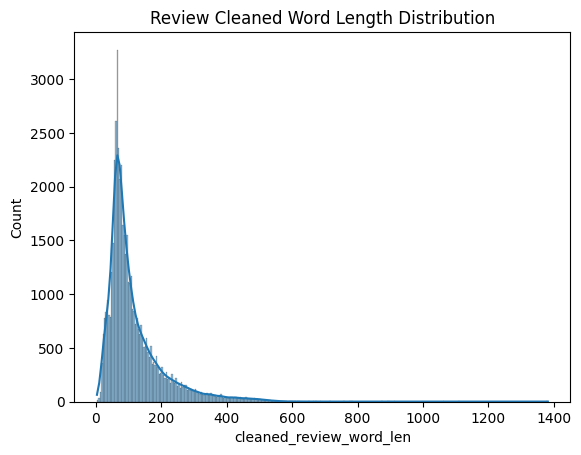

In [14]:
sns.histplot(df["cleaned_review_word_len"], kde=True)
plt.title("Review Cleaned Word Length Distribution")
if SAVE_FIG:
    plt.savefig(os.path.join(FIG_DIR,"review_cleaned_word_length_histplot.png"))
plt.show()

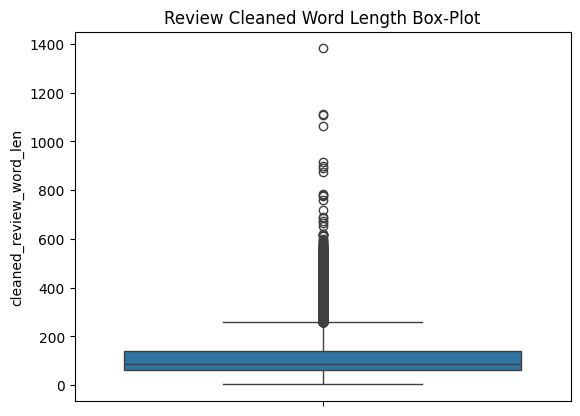

In [15]:
sns.boxplot(df["cleaned_review_word_len"])
plt.title("Review Cleaned Word Length Box-Plot")
if SAVE_FIG:
    plt.savefig(os.path.join(FIG_DIR, "review_cleaned_word_length_boxplot.png"))
plt.show()

### Charecter length

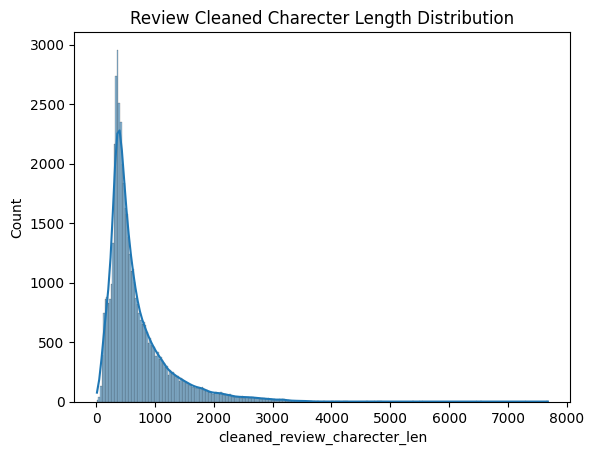

In [16]:
sns.histplot(df["cleaned_review_charecter_len"], kde=True)
plt.title("Review Cleaned Charecter Length Distribution")
if SAVE_FIG:
    plt.savefig(os.path.join(FIG_DIR,"review_cleaned_charecter_length_histplot.png"))
plt.show()

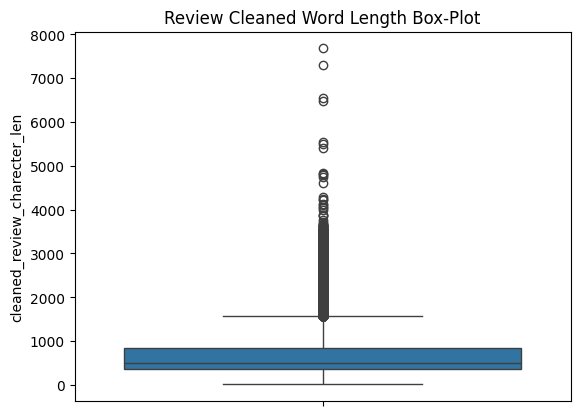

In [17]:
sns.boxplot(df["cleaned_review_charecter_len"])
plt.title("Review Cleaned Word Length Box-Plot")
if SAVE_FIG:
    plt.savefig(os.path.join(FIG_DIR, "review_cleaned_charecter_length_boxplot.png"))
plt.show()

### Counting Outlires in Reviwes using Word Lengeth

In [18]:
q1, q3 = df["cleaned_review_word_len"].quantile([.25, .75])
q1, q3

(62.0, 141.0)

In [19]:
iqr = q3 - q1
iqr

79.0

In [20]:
lower_limit = q1 - (1.5 * iqr)
upper_limit = q3 + (1.5 * iqr)
lower_limit, upper_limit

(-56.5, 259.5)

In [21]:
(df['cleaned_review_word_len'] < lower_limit).sum()

np.int64(0)

In [22]:
# Only using upper_limit because the min value for word len is 0 but lower_limit is -109
outlires = df[df['cleaned_review_word_len'] > upper_limit]
outlires

,review,sentiment,review_charecters_len,review_word_len,has_html,cleaned_review,tokens,cleaned_review_charecter_len,cleaned_review_word_len,cleaned_review_has_html
26,"""The Cell"" is an exotic masterpiece, a dizzyin...",positive,2448,589,True,cell exotic masterpiece dizzying trip vast min...,"[cell, exotic, masterpiece, dizzying, trip, va...",1571,269,False
29,'War movie' is a Hollywood genre that has been...,positive,3047,636,True,war movie hollywood genre done redone many tim...,"[war, movie, hollywood, genre, done, redone, m...",2313,357,False
33,One of the most significant quotes from the en...,positive,3228,679,True,one significant quote entire film pronounced h...,"[one, significant, quote, entire, film, pronou...",2351,361,False
48,Preston Sturgis' THE POWER AND THE GLORY was u...,positive,3115,720,True,preston sturgis power glory unseen public near...,"[preston, sturgis, power, glory, unseen, publi...",2150,364,False
51,"***SPOILERS*** All too, in real life as well a...",positive,2637,636,True,spoiler real life well movie familiar story ha...,"[spoiler, real, life, well, movie, familiar, s...",1721,311,False
...,...,...,...,...,...,...,...,...,...,...
49925,"What a disaster! Normally, when one critiques ...",negative,3317,759,True,disaster normally one critique historical movi...,"[disaster, normally, one, critique, historical...",2215,363,False
49943,"""Sir"" has played Lear over 200 times,but tonig...",positive,2856,618,True,sir played lear timesbut tonight cannot rememb...,"[sir, played, lear, timesbut, tonight, cannot,...",2113,309,False
49948,"It is the early morning of our discontent, and...",negative,4626,1023,True,early morning discontent friend mine gotten wa...,"[early, morning, discontent, friend, mine, got...",3110,486,False
49959,"My thoughts on the movie, 9<br /><br />It was ...",negative,2689,652,True,thought movie good good visually great pleased...,"[thought, movie, good, good, visually, great, ...",1713,288,False


In [23]:
random.choice(outlires['cleaned_review'].tolist())

'yep dressed kill kind movie like kalifornia different remember movie star brad pitt serial killer welcomed couple traveler trip california buddy might good company along way watch movie always like know anything plot watching surprise may get even cooler kalifornia watched last year first time never realized suspense movie found shocked movie went got even better edge seat almost kissing monitor close discussing dressed kill right watched movie today watched others movie brian de palma say really know well work tell afar movie great could carrie missionimpossible watched carrie tv really desperate get dvd copy tell movie great missionimpossible also today watched third movie depalma well dressed kill movie like kalifornia movie go go completely different would expect watching curious scene museum dickinson follows mysterious man cab end together apartment room may guess may happened movie reached scene elevator movie went completely different path watching rest movie really liked howe

In [24]:
df[df["cleaned_review_word_len"] < 60]

,review,sentiment,review_charecters_len,review_word_len,has_html,cleaned_review,tokens,cleaned_review_charecter_len,cleaned_review_word_len,cleaned_review_has_html
5,"Probably my all-time favorite movie, a story o...",positive,510,125,False,probably alltime favorite movie story selfless...,"[probably, alltime, favorite, movie, story, se...",314,54,False
9,If you like original gut wrenching laughter yo...,positive,132,34,True,like original gut wrenching laughter like movi...,"[like, original, gut, wrenching, laughter, lik...",85,17,False
10,Phil the Alien is one of those quirky films wh...,negative,448,101,True,phil alien one quirky film humour based around...,"[phil, alien, one, quirky, film, humour, based...",312,49,False
13,The cast played Shakespeare.<br /><br />Shakes...,negative,499,122,True,cast played shakespeareshakespeare losti appre...,"[cast, played, shakespeareshakespeare, losti, ...",312,49,False
14,This a fantastic movie of three prisoners who ...,positive,219,51,False,fantastic movie three prisoner become famous o...,"[fantastic, movie, three, prisoner, become, fa...",153,26,False
...,...,...,...,...,...,...,...,...,...,...
49963,If you like really shocking movies this is for...,negative,267,74,False,like really shocking movie acting worst ever s...,"[like, really, shocking, movie, acting, worst,...",159,32,False
49968,"I must say as a girl with a cowboy of my own,I...",positive,222,66,False,must say girl cowboy owni love flickit left lo...,"[must, say, girl, cowboy, owni, love, flickit,...",144,30,False
49969,I must admit that this is one of the worst mov...,negative,238,63,False,must admit one worst movie ever seen thought d...,"[must, admit, one, worst, movie, ever, seen, t...",151,29,False
49994,This is your typical junk comedy.<br /><br />T...,negative,565,142,True,typical junk comedythere almost laugh genuine ...,"[typical, junk, comedythere, almost, laugh, ge...",337,57,False


In [25]:
random.choice(df[df["cleaned_review_word_len"] < 60]['cleaned_review'].tolist())

'little nonsense cherished wisest menif smart watch movie smart alive wonderful romp wonderful premise period piece done acute eye detailwalter matthau meg ryan tim robbins et al wonderfulrent sit relax take smile little enjoy thank'

### Counting Outlires in Reviwes using Charecter Lengeth

In [26]:
q1, q3 = df["cleaned_review_charecter_len"].quantile([.25, .75])
q1, q3

(360.0, 842.0)

In [27]:
iqr = q3 - q1
iqr

482.0

In [28]:
lower_limit = q1 - (1.5 * iqr)
upper_limit = q3 + (1.5 * iqr)
lower_limit, upper_limit

(-363.0, 1565.0)

In [29]:
(df['cleaned_review_charecter_len'] < lower_limit).sum()

np.int64(0)

In [30]:
# Only using upper_limit because the min value for word len is 0 but lower_limit is -109
outlires = df[df['cleaned_review_charecter_len'] > upper_limit]
outlires

,review,sentiment,review_charecters_len,review_word_len,has_html,cleaned_review,tokens,cleaned_review_charecter_len,cleaned_review_word_len,cleaned_review_has_html
26,"""The Cell"" is an exotic masterpiece, a dizzyin...",positive,2448,589,True,cell exotic masterpiece dizzying trip vast min...,"[cell, exotic, masterpiece, dizzying, trip, va...",1571,269,False
29,'War movie' is a Hollywood genre that has been...,positive,3047,636,True,war movie hollywood genre done redone many tim...,"[war, movie, hollywood, genre, done, redone, m...",2313,357,False
30,"Taut and organically gripping, Edward Dmytryk'...",positive,2043,423,True,taut organically gripping edward dmytryks cros...,"[taut, organically, gripping, edward, dmytryks...",1571,236,False
33,One of the most significant quotes from the en...,positive,3228,679,True,one significant quote entire film pronounced h...,"[one, significant, quote, entire, film, pronou...",2351,361,False
48,Preston Sturgis' THE POWER AND THE GLORY was u...,positive,3115,720,True,preston sturgis power glory unseen public near...,"[preston, sturgis, power, glory, unseen, publi...",2150,364,False
...,...,...,...,...,...,...,...,...,...,...
49925,"What a disaster! Normally, when one critiques ...",negative,3317,759,True,disaster normally one critique historical movi...,"[disaster, normally, one, critique, historical...",2215,363,False
49943,"""Sir"" has played Lear over 200 times,but tonig...",positive,2856,618,True,sir played lear timesbut tonight cannot rememb...,"[sir, played, lear, timesbut, tonight, cannot,...",2113,309,False
49948,"It is the early morning of our discontent, and...",negative,4626,1023,True,early morning discontent friend mine gotten wa...,"[early, morning, discontent, friend, mine, got...",3110,486,False
49959,"My thoughts on the movie, 9<br /><br />It was ...",negative,2689,652,True,thought movie good good visually great pleased...,"[thought, movie, good, good, visually, great, ...",1713,288,False


In [31]:
random.choice(outlires['cleaned_review'].tolist())

'saw zp first released found major disappointment script seemed forced arch fakey politics upfront ridiculous let face still lovespell known blowup still completely shaken love twisted sort nostalgia evokes oh well good luck mebut time march time kind zp time teacher revisit film every ten year get better better age zp experienceand really linked blowup creator lategreat mr antonionitwelve year ago great good fortune see absolutely pristine print projected correct size immense restored italian government cultural agency know good work art see know importance keeping thing beauty good shape day remember gasp audience first shot death valley appeared like thousand volt visual shock antonioni intentionally delivered wake new level awareness indeed follows point entirely different sort placewhat astonishing film coming owni remember second time around seeing early begun feel affection towards film whole towards daria mark particular whereas two seemed like smartalecky shadow version zeffer

In [32]:
df[df["cleaned_review_charecter_len"] < 60].head()

,review,sentiment,review_charecters_len,review_word_len,has_html,cleaned_review,tokens,cleaned_review_charecter_len,cleaned_review_word_len,cleaned_review_has_html
413,"A rating of ""1"" does not begin to express how ...",negative,77,18,False,rating begin express dull depressing relentles...,"[rating, begin, express, dull, depressing, rel...",52,8,False
1417,Hated it with all my being. Worst movie ever. ...,negative,75,19,False,hated worst movie ever mentally scarred help b...,"[hated, worst, movie, ever, mentally, scarred,...",46,8,False
3709,"Long, boring, blasphemous. Never have I been s...",negative,63,14,False,long boring blasphemous never glad see ending ...,"[long, boring, blasphemous, never, glad, see, ...",49,9,False
9451,"Did Sandra (yes, she must have) know we would ...",positive,124,36,True,sandra yes must know would still nine year lat...,"[sandra, yes, must, know, would, still, nine, ...",50,11,False
10973,"This is a terrible movie, don't waste your mon...",negative,82,26,False,terrible movie waste money even watch free say,"[terrible, movie, waste, money, even, watch, f...",39,8,False


In [33]:
df[df["cleaned_review_charecter_len"] < 60].shape

(38, 10)

In [34]:
random.choice(df[df["cleaned_review_charecter_len"] < 60]['cleaned_review'].tolist())

'movie always broadway movie classic long still people sing dance act'

## Word Clouds

In [35]:
all_raw_text = ' '.join(df["review"])
all_cleaned_text = ' '.join(df["cleaned_review"])

all_pos_raw_text = ' '.join(df.loc[df["sentiment"] == "positive", "review"])
all_neg_raw_text = ' '.join(df.loc[df["sentiment"] == "negative", "review"])

all_pos_cleaned_text = ' '.join(df.loc[df["sentiment"] == "positive", "cleaned_review"])
all_neg_cleaned_text = ' '.join(df.loc[df["sentiment"] == "negative", "cleaned_review"])

### All Reviews

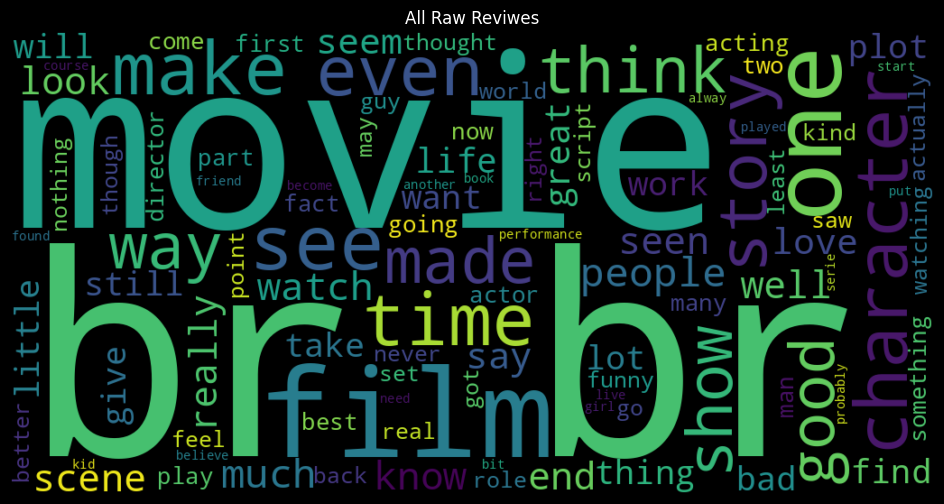

In [36]:
## raw text
wordcloud = WordCloud(
    width=1024, height=512,
    background_color="black",
    max_words=100
).generate(all_raw_text)

plt.figure(figsize=(12,6), facecolor="black")
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("All Raw Reviwes", color="white")
plt.axis("off")
if SAVE_FIG:
    plt.savefig(os.path.join(FIG_DIR, "wordcloud_all_reviwes.png"))
plt.show()

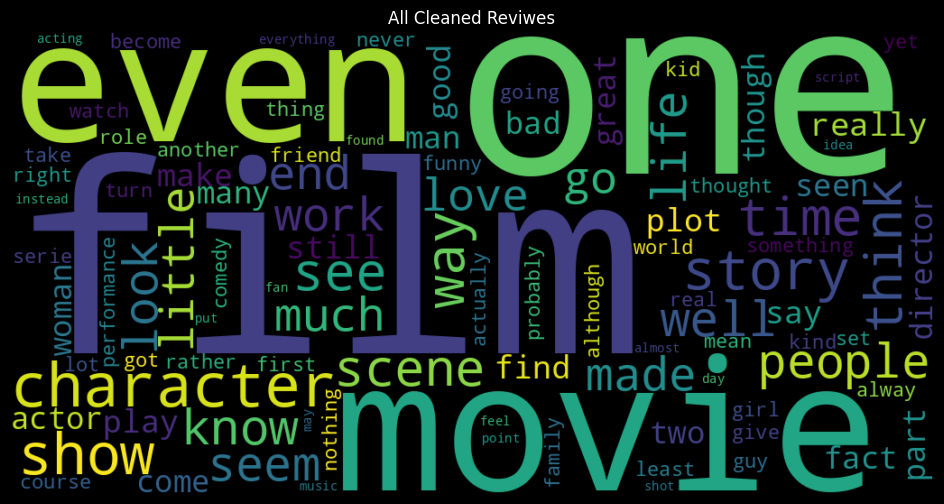

In [37]:
## cleaned text
wordcloud = WordCloud(
    width=1024, height=512,
    background_color="black",
    max_words=100
).generate(all_cleaned_text)

plt.figure(figsize=(12,6), facecolor="black")
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("All Cleaned Reviwes", color="white")
plt.axis("off")
if SAVE_FIG:
    plt.savefig(os.path.join(FIG_DIR, "wordcloud_all_cleaned_reviwes.png"))
plt.show()

### All Positive Reviwes

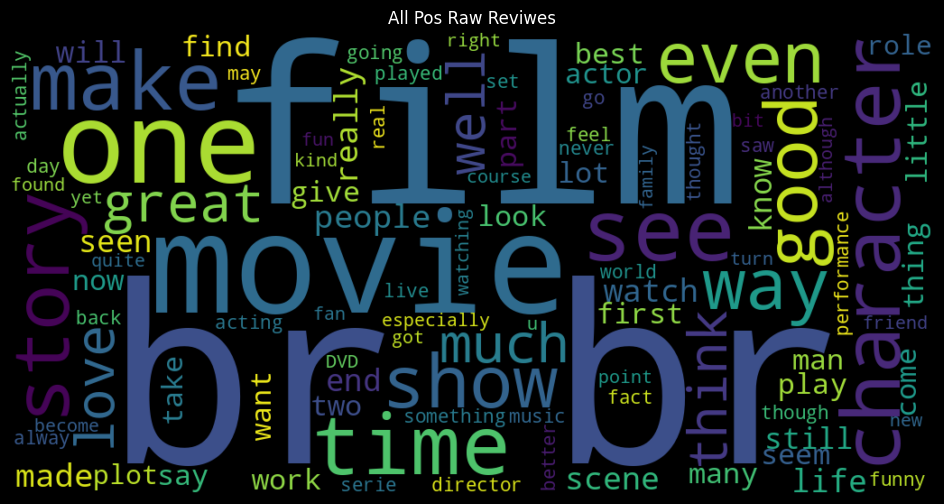

In [38]:
## all_pos_raw_text
wordcloud = WordCloud(
    width=1024, height=512,
    background_color="black",
    max_words=100
).generate(all_pos_raw_text)

plt.figure(figsize=(12,6), facecolor='black')
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("All Pos Raw Reviwes", color="white")
plt.axis('off')
if SAVE_FIG:
    plt.savefig(os.path.join(FIG_DIR, "wordcloud_all_pos_reviwes.png"))
plt.show()

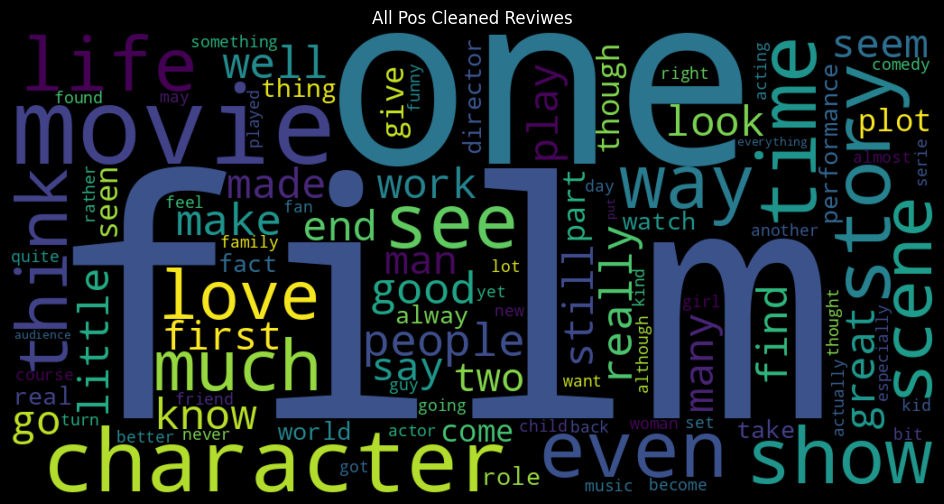

In [39]:
## all_pos_cleaned_text
wordcloud = WordCloud(
    width=1024, height=512,
    background_color="black",
    max_words=100
).generate(all_pos_cleaned_text)

plt.figure(figsize=(12,6), facecolor="black")
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("All Pos Cleaned Reviwes", color="white")
plt.axis('off')
if SAVE_FIG:
    plt.savefig(os.path.join(FIG_DIR, "wordcloud_all_pos_cleaned_reviwes.png"))
plt.show()

### All Negative Reviwes

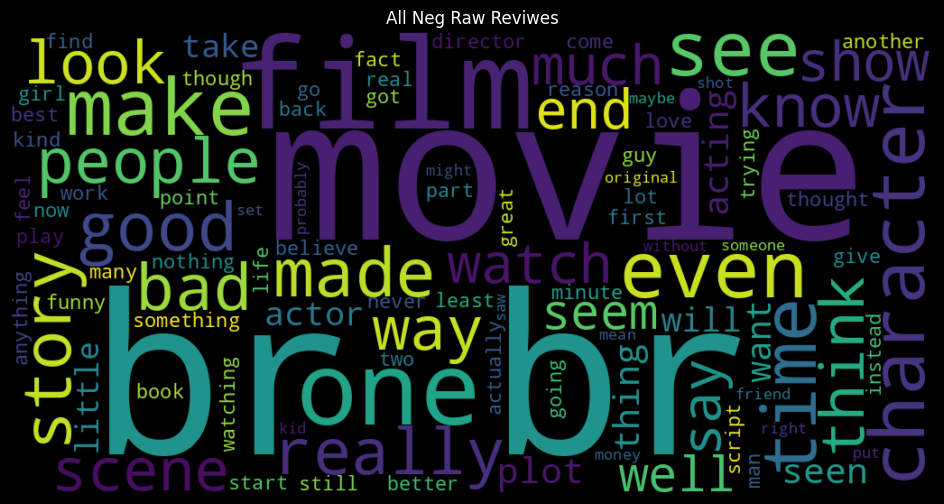

In [40]:
## all_neg_raw_text text
wordcloud = WordCloud(
    width=1024, height=512,
    background_color="black",
    max_words=100
).generate(all_neg_raw_text)

plt.figure(figsize=(12,6), facecolor="black")
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("All Neg Raw Reviwes", color="white")
plt.axis('off')
if SAVE_FIG:
    plt.savefig(os.path.join(FIG_DIR, "wordcloud_all_neg_reviwes.png"))
plt.show()

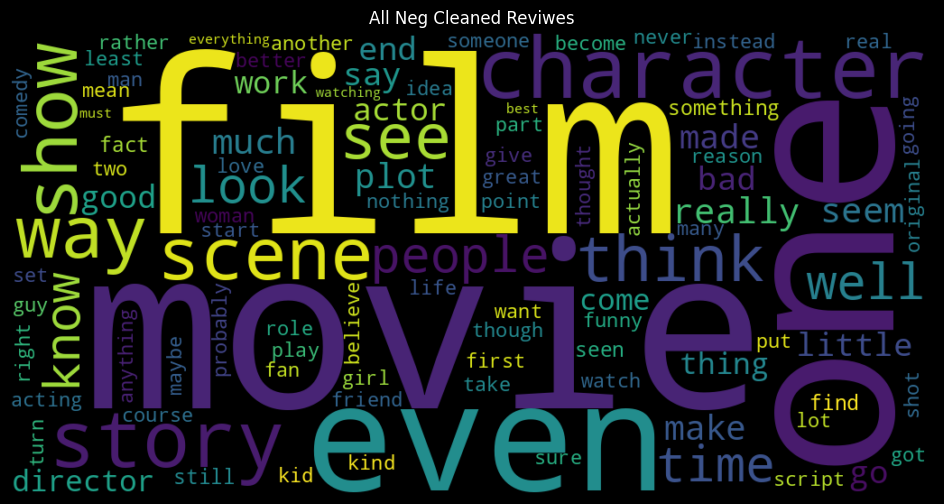

In [41]:
## all_neg_cleaned_text
wordcloud = WordCloud(
    width=1024, height=512,
    background_color="black",
    max_words=100
).generate(all_neg_cleaned_text)

plt.figure(figsize=(12,6), facecolor="black")
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("All Neg Cleaned Reviwes", color="white")
plt.axis('off')
if SAVE_FIG:
    plt.savefig(os.path.join(FIG_DIR, "wordcloud_all_neg_cleaned_reviwes.png"))
plt.show()